# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина для определения будущей цены.

## 1.2 Описание
    Проблема предсказания вкусовых качеств вина одна из основных для винодельческого бизнеса. 
Предсказание класса вина позволяет увеличить рентабельность бизнеса.

В этой задаче мы просим вас провести анализ того, какой класс вина будет соответствовать известным физико-химическим свойствам вина. В частности, мы просим вас применить инструменты машинного обучения, чтобы предсказать, к какому классу следует отнести вино по его известным физико-химическим свойствам.


[Описание от Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import os

import requests , shutil

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции


In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( f'{var_name}')# + str( round( float( df[ var_name ].skew() ) , ) ) ) 
        # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [7]:
df=pd.read_csv('I:/YandexDisk/YandexDisk/Книги/Курс/Нетология/профессия_DS_middle/15_Менеджмент_DS_проектов/DZ_3_ZAK-14/2_Данные_проекта/winequalityN.csv')

In [8]:
df.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

## 2.4 Статистика и визуализации

In [9]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

1. fixed acidity: Фиксированная кислотность

1. volatile acidity: изменчивость кислотности 

1. citric acid: лимонная кислота

1. residual sugar: содержание сахара

1. chlorides: хлориды

1. free sulfur dioxide: активный диоксид серы

1. total sulfur dioxide: суммарный диоксид серы

1. density: плотность

1. pH: pH

1. sulphates: сульфаты

1. alcohol: алкоголь

1. quality: качество(класс)


[Больше информации на сайте Kaggle](https://www.kaggle.com/c/titanic/data)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

1. Фиксированная кислотность обусловлена наличием нелетучих кислот в вине. Например, винная, лимонная или яблочная кислоты. Данный тип кислот участвует в сбалансированности вкуса вина, привносит свежесть вкусу.

1. Изменчивая кислотность обусловлена наличием летучих кислот в вине, например, таких как уксусная кислота.

1. Остаточный сахар - характеристика, показывающая количество сахара, который не был превращен в спирт в процессе ферментации вина. Участвует в сладости вкуса вина.

1. Диоксид серы (они же сульфиты) используются в виноделии в качестве безопасного антисептика. Сульфиты не дают вину скисать и потерять свои вкусовые качества. Присутствуют в вине в свободном виде (газообразном) и связанном виде (соединившись с водой).

1. Характеристика рН может выступать характеристикой цвета вина. Вина с высоким pH темнее и имеют фиолетовый оттенок цвета. Вина с низким pH светлее и имеют ярко-розовый и ярко-красный оттенок цвета. 

1. Количество спирта характеризует крепость вина.

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

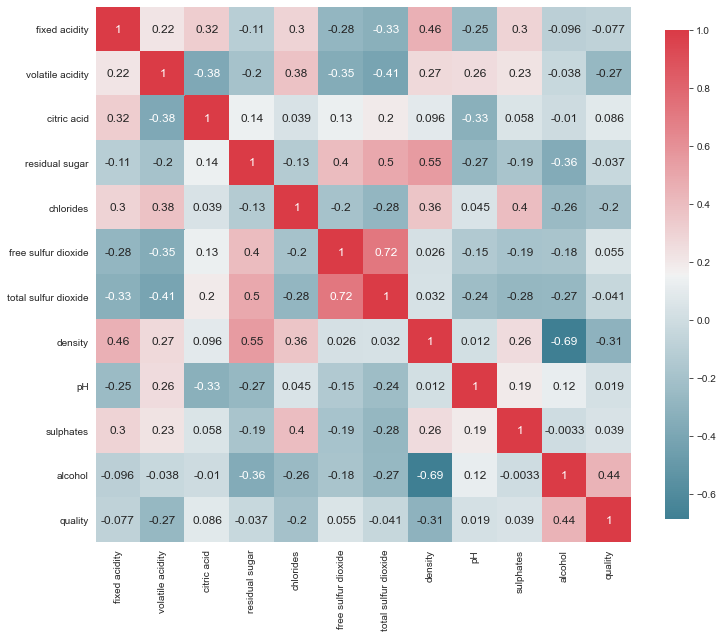

In [10]:
plot_correlation_map( df )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и классом вина
Начнем с рассмотрения взаимосвязи между алкоголем и классом.

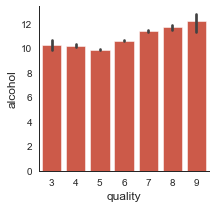

In [11]:
plot_categories( df , cat = 'quality' , target = 'alcohol' )

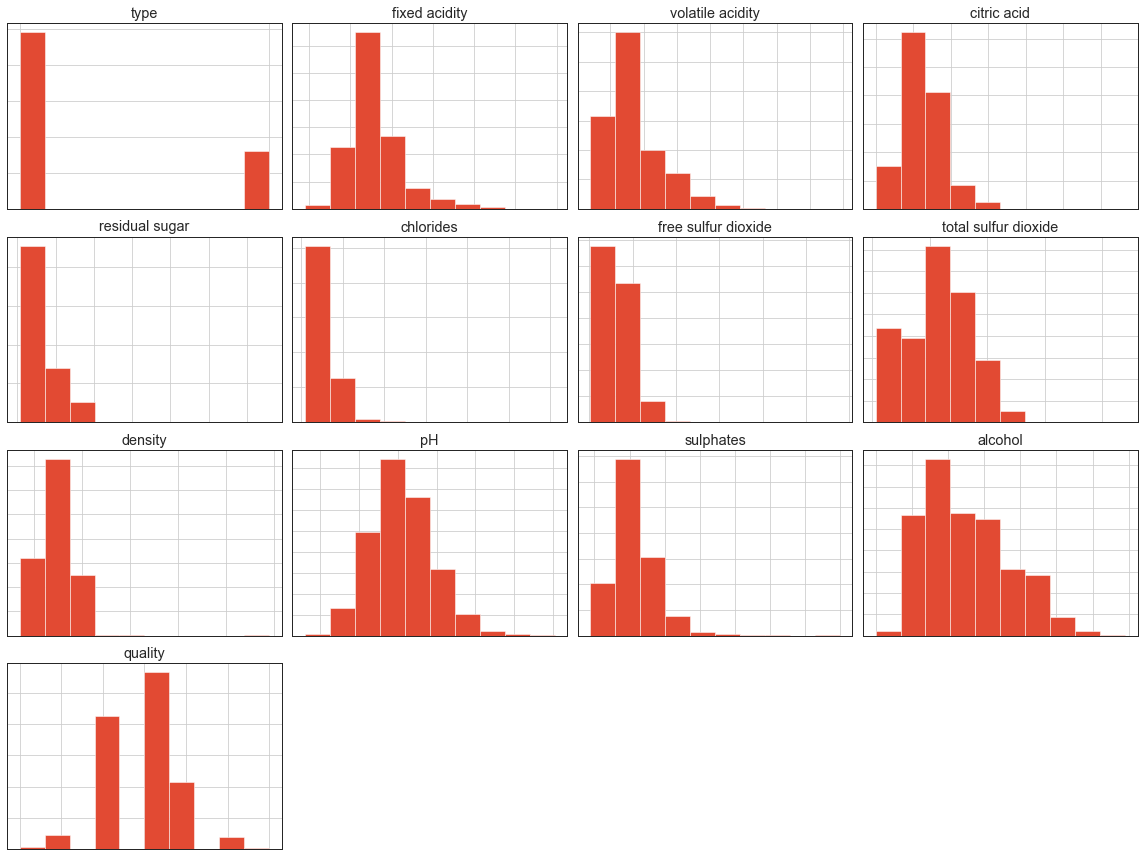

In [12]:
plot_histograms( df , ['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], 4 , 4 )

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменные Embarked, Pclass и Sex рассматриваются как категориальные переменные. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [13]:
#df=pd.read_csv('winequalityN.csv')
df=pd.read_csv('I:/YandexDisk/YandexDisk/Книги/Курс/Нетология/профессия_DS_middle/15_Менеджмент_DS_проектов/DZ_3_ZAK-14/2_Данные_проекта/winequalityN.csv')

In [14]:
le = preprocessing.LabelEncoder()
type1 = le.fit_transform(df["type"])
df['type1'] = pd.DataFrame(data=type1)

In [15]:
#df[['type_red',	'type_white']] = pd.get_dummies( df.type , prefix='type' )
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type1
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [16]:
del(df['type'])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type1
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


## 3.2 Удалить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - удалить пропущенные значения в обучающем наборе.

In [17]:
df=df.dropna()


### 3.3 Создание датасетов

Отделяем данные для обучения и для проверки

In [18]:
y=df['quality']
X=df.copy()
del(X['quality'])

from sklearn.preprocessing import StandardScaler
transformer = Normalizer().fit(X)
X = pd.DataFrame(transformer.transform(X))

train_X , valid_X , train_y , valid_y = train_test_split( X , y , train_size = 0.2 )


### 3.3.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


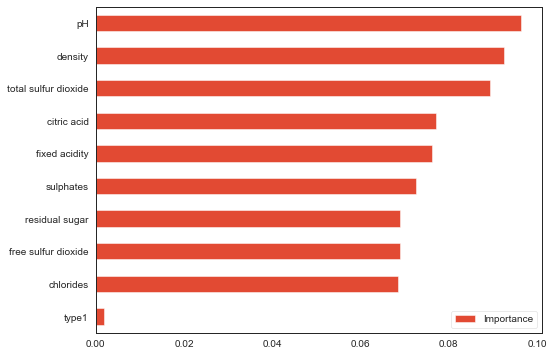

In [19]:
vis_X , val_X , vis_y , val_y = train_test_split( df[['type1', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] , df['quality'] , train_size = 0.2 )
plot_variable_importance(vis_X, vis_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [20]:
model = LogisticRegression()

## 4.2 Обучение модели

In [21]:
model.fit( train_X , train_y )

LogisticRegression()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [22]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.44040247678018574 0.4438213111583833


# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [26]:
test_Y = model.predict( valid_X )

test = pd.DataFrame( { 'Class_valid': valid_y , 'Class_predict': test_Y } )
test.shape
test.head()
test.to_csv( 'I:/YandexDisk/YandexDisk/Книги/Курс/Нетология/профессия_DS_middle/15_Менеджмент_DS_проектов/DZ_3_ZAK-14/4_Результаты_проекта/wine_predict.csv' , index = False )
